In [1]:
training="arc-agi_training_challenges.json"
train_sol="arc-agi_training_solutions.json"

In [ ]:
# --- Install dependencies ---
!pip install -q langgraph langchain-ollama langchain-core matplotlib numpy

# --- Pull Ollama models ---
!ollama pull qwen2.5:32b
!ollama pull deepseek-r1:8b


Showing challenge: bcb3040b


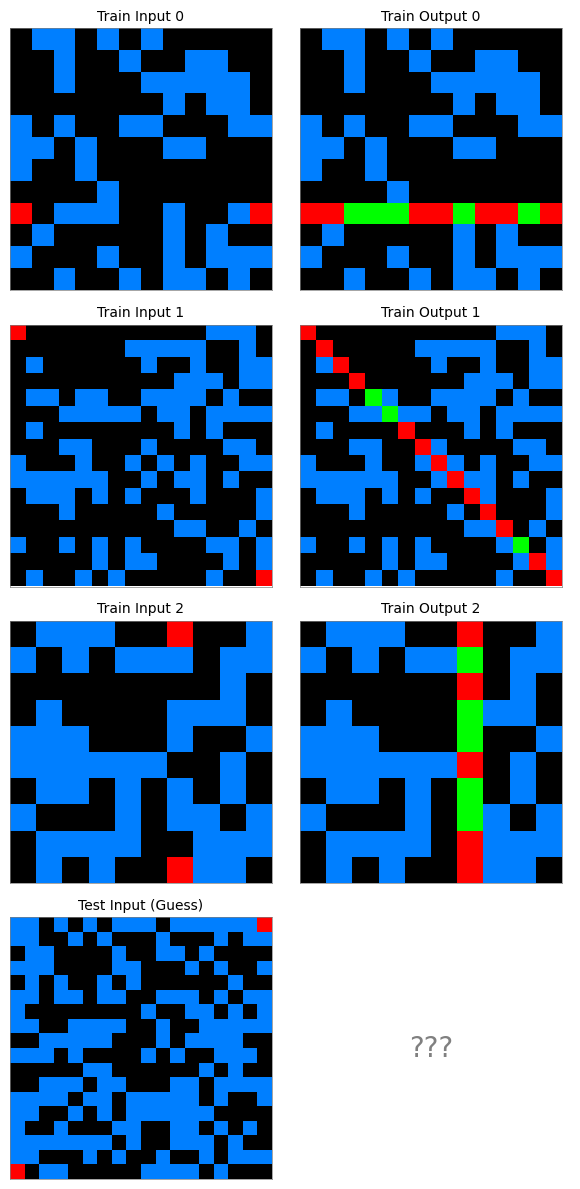

In [7]:
import json, random
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# CONFIG
# =====================================================
training_path = "arc-agi_training_challenges.json"

# Fixed ARC palette
COLOR_MAP = {
    0: (0, 0, 0),        # black
    1: (0, 0.5, 1),      # blue
    2: (1, 0, 0),        # red
    3: (0, 1, 0),        # green
    4: (1, 1, 0),        # yellow
    5: (0.5, 0.5, 0.5),  # gray
    6: (1, 0.4, 0.7),    # pink
    7: (1, 0.6, 0),      # orange
    8: (0.5, 0.8, 1),    # light blue
    9: (0.6, 0, 0),      # maroon
}

def show_grid(grid, ax, title=None):
    arr = np.array(grid)
    rgb = np.array([[COLOR_MAP[val] for val in row] for row in arr])
    ax.imshow(rgb, interpolation="nearest")
    ax.set_xticks([]); ax.set_yticks([])
    if title:
        ax.set_title(title, fontsize=10)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_edgecolor("gray")

# =====================================================
# LOAD + SHOW RANDOM CHALLENGE
# =====================================================
with open(training_path, "r") as f:
    challenges = json.load(f)

task_id = random.choice(list(challenges.keys()))
task = challenges[task_id]
print(f"Showing challenge: {task_id}")

train_pairs = task["train"]
test_pairs = task["test"]

n_train = len(train_pairs)
fig, axes = plt.subplots(n_train + 1, 2, figsize=(6, 3 * (n_train + 1)), facecolor="white")

for i, pair in enumerate(train_pairs):
    show_grid(pair["input"], axes[i, 0], f"Train Input {i}")
    show_grid(pair["output"], axes[i, 1], f"Train Output {i}")

# show test input (guess)
show_grid(test_pairs[0]["input"], axes[n_train, 0], "Test Input (Guess)")
axes[n_train, 1].axis("off")
axes[n_train, 1].text(0.5, 0.5, "???", ha="center", va="center", fontsize=20, color="gray")

plt.tight_layout()
plt.show()


In [8]:
import json, random
import numpy as np
import matplotlib.pyplot as plt
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage

# =====================================================
# LANGGRAPH PIPELINE
# =====================================================
from typing import TypedDict, List
test_input = test_pairs[0]["input"]

class AgentState(TypedDict, total=False):
    hypotheses: List[str]
    guesses: List[str]

builder = StateGraph(AgentState)

# ----------------- NODE 1: HYPOTHESIS GENERATION -----------------
def node_hypothesis(state: AgentState):
    llm = ChatOllama(model="qwen2.5:32b", temperature=0.4)
    prompt = f"""
You are a math puzzle solver. You start with an input grid that undergoes certain transformations to become an output grid.
Given the following train examples (input → output).
Infer 5 concise possible rules or hypotheses
that explain the transformation pattern. Each hypothesis needs to be independent and different than the others, no two should be the same or depend on the 
other hypothesis.

Your hypothesis should be extrememly detailed, leave no ambiguity. Explain what is being transformed, how the values change, the relationship between values, etc.
Your hypothesis will be passed to an execution, that will take your response and solve the puzzle with it, so if you are not specific it will be lost.

An example would be:

┌───┬───┬───┐
│ 1 2 3 │
│ 4 5 6 │
│ 0 8 7 │
└───┴───┴───┘

**Output grid:**
┌───┬───┬───┐
│ 0 2 3 │
│ 1 5 6 │
│ 4 8 7 │
└───┴───┴───┘

**Steps:**
Step 1: Move the zero to the top row.
Step 2: Swap the positions of 1 and 0.
Step 3: Swap the positions of 4 and 0.


<TRAINING EXAMPLES>
{train_pairs}

List them as:
1. ...
2. ...
3. ...
4. ...
5. ...
"""
    resp = llm.invoke([HumanMessage(content=prompt)])
    text = resp.content.strip()
    print("\n=== Hypotheses Generated ===\n", text, "\n")
    return {"hypotheses": [h.strip() for h in text.split("\n") if h.strip()]}

builder.add_node("hypothesis", node_hypothesis)

# ----------------- NODES 2–5: EXECUTION -----------------
def make_executor_node(idx: int, test_input):
    def executor(state: AgentState):
        if len(state["hypotheses"]) < idx:
            return {}
        hypothesis = state["hypotheses"][idx - 1]
        llm = ChatOllama(model="deepseek-r1:8b", temperature=0.2)
        prompt = f"""
You are an ARC transformation executor.
Given this rule hypothesis:

"{hypothesis}"

and the following test input grid:
{test_input}

Predict the output grid (as a JSON array of integers) that would result if this hypothesis is true.
Only output the grid, no text.
"""
        resp = llm.invoke([HumanMessage(content=prompt)])
        guess = resp.content.strip()
        print(f"\n=== Guess from Executor {idx} ===\n{guess}\n")
        return {"guesses": state.get("guesses", []) + [guess]}
    return executor

# when adding nodes, pass test_input explicitly
for i in range(1, 5):
    builder.add_node(f"exec_{i}", make_executor_node(i, test_input))

# ----------------- GRAPH CONNECTIONS -----------------
from langgraph.graph import START

# define entrypoint
builder.add_edge(START, "hypothesis")

# define pipeline sequence
builder.add_edge("hypothesis", "exec_1")
builder.add_edge("exec_1", "exec_2")
builder.add_edge("exec_2", "exec_3")
builder.add_edge("exec_3", "exec_4")
builder.add_edge("exec_4", END)

compiled_graph = builder.compile()

# =====================================================
# RUN PIPELINE
# =====================================================
result = compiled_graph.invoke({})
print("\nFinal Result State:\n", result)


=== Hypotheses Generated ===
 Based on the provided training examples and their transformations, here are five detailed hypotheses that could explain the transformation pattern:

1. **Increment Specific Values by Count of Neighbors:**
   - For every cell with a value greater than 0 (e.g., 1 or 2), increment its value by the count of neighboring cells containing the same value.
   - A neighbor is defined as any adjacent cell in the grid, including diagonally adjacent ones.
   - Example: If a cell contains '1' and has two neighbors also with '1', then this cell's new value will be 3 (1 + 2).

2. **Increment Specific Values Based on Row/Column Sum:**
   - For each cell containing the values 1 or 2, increment its value by the sum of all cells in its row that contain a non-zero value.
   - Example: If a cell with '1' is in a row where there are three other cells also containing '1', then this cell's new value will be 4 (1 + 3).

3. **Increment Specific Values Based on Unique Neighbor Count

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from pathlib import Path
import os

# =====================================================
# NEW GRAPH BUILDER
# =====================================================
builder_v2 = StateGraph(AgentState)

# =====================================================
# NODE 1: HYPOTHESIS (GPT-5-mini)
# =====================================================
def node_hypothesis_v2(state: AgentState):
    api_path = Path("API.txt")
    api_key = api_path.read_text().strip()
    os.environ["OPENAI_API_KEY"] = api_key

    llm = ChatOpenAI(model="gpt-5-mini", temperature=0.4)

    prompt = f"""
You are a math puzzle solver. You start with an input grid that undergoes certain transformations to become an output grid.
Given the following train examples (input → output).
Infer 5 concise possible rules or hypotheses
that explain the transformation pattern. Each hypothesis needs to be independent and different than the others, no two should be the same or depend on the 
other hypothesis.

Your hypothesis should be extrememly detailed, leave no ambiguity. Explain what is being transformed, how the values change, the relationship between values, etc.
Your hypothesis will be passed to an execution, that will take your response and solve the puzzle with it, so if you are not specific it will be lost.

An example would be:

┌───┬───┬───┐
│ 1 2 3 │
│ 4 5 6 │
│ 0 8 7 │
└───┴───┴───┘

**Output grid:**
┌───┬───┬───┐
│ 0 2 3 │
│ 1 5 6 │
│ 4 8 7 │
└───┴───┴───┘

**Steps:**
Step 1: Move the zero to the top row.
Step 2: Swap the positions of 1 and 0.
Step 3: Swap the positions of 4 and 0.


<TRAINING EXAMPLES>
{train_pairs}

List them as:
1. ...
2. ...
3. ...
4. ...
5. ...
"""
    resp = llm.invoke([HumanMessage(content=prompt)])
    text = resp.content.strip()
    print("\n=== Hypotheses Generated ===\n", text, "\n")

    hypotheses = [line.strip() for line in text.split("\n") if line.strip()]
    return {"hypotheses": hypotheses}

builder_v2.add_node("hypothesis", node_hypothesis_v2)

# =====================================================
# NODES 2–5: EXECUTION (same as before)
# =====================================================
def make_executor_node(idx: int, test_input):
    def executor(state: AgentState):
        if len(state["hypotheses"]) < idx:
            return {}
        hypothesis = state["hypotheses"][idx - 1]
        llm = ChatOllama(model="deepseek-r1:8b", temperature=0.2)
        prompt = f"""
You are an ARC transformation executor.
Given this rule hypothesis:

"{hypothesis}"

and the following test input grid:
{test_input}

Predict the output grid (as a JSON array of integers) that would result if this hypothesis is true.
Only output the grid, no text.
"""
        resp = llm.invoke([HumanMessage(content=prompt)])
        guess = resp.content.strip()
        print(f"\n=== Guess from Executor {idx} ===\n{guess}\n")
        return {"guesses": state.get("guesses", []) + [guess]}
    return executor

for i in range(1, 5):
    builder_v2.add_node(f"exec_{i}", make_executor_node(i, test_input))

# =====================================================
# GRAPH CONNECTIONS
# =====================================================
builder_v2.add_edge(START, "hypothesis")
builder_v2.add_edge("hypothesis", "exec_1")
builder_v2.add_edge("exec_1", "exec_2")
builder_v2.add_edge("exec_2", "exec_3")
builder_v2.add_edge("exec_3", "exec_4")
builder_v2.add_edge("exec_4", END)

# =====================================================
# COMPILE & RUN
# =====================================================
compiled_graph_v2 = builder_v2.compile()
result_v2 = compiled_graph_v2.invoke({})
print("\nFinal Result State:\n", result_v2)



=== Hypotheses Generated ===
 1. Straight discrete line segment (Bresenham) between the two 2-cells; map values along that segment
   - Identification: find the two cells whose value is 2. Compute the discrete straight line segment connecting them using an integer-line algorithm (Bresenham) that visits the minimal set of grid cells approximating the continuous straight line between the two coordinates. The segment includes both 2 endpoints and every intermediate grid cell that Bresenham chooses.
   - Transformation rule on that segment only (all other cells remain unchanged):
     - If a cell on the Bresenham segment has value 2, leave it as 2.
     - If it has value 1, change it to 3.
     - If it has value 0, change it to 2.
   - Determinism: if the two 2s are aligned horizontally, vertically or on a 45° diagonal, Bresenham picks exactly the row/column/diagonal cells between them; otherwise pick the unique integer-line cells Bresenham returns. The mapping applies exactly to those re